# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import itertools
%matplotlib inline

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
wiki.head()

URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  
0  digby morrell born 10 october 1979 is a former...  
1  alfred j lewy aka sandy lewy graduated from un...  
2  harpdog brown is a singer and harmonica player...  
3  franz rottensteiner born in waidmannsfeld lowe...  
4  henry krvits born 30 december 1974 in tallinn ...

## Extract word count vectors

As we have seen in Course 1, we can extract word count vectors using a GraphLab utility function.  We add this as a column in `wiki`.

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix((data, indices, indptr), shape)

In [5]:
word_count = load_sparse_csr('people_wiki_word_count.npz')  #word index to count of words
map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json', typ='series')

In [6]:
word_count

<59071x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [7]:
word_count[2,:]

<1x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [8]:
def count_words(X, vocabulary):
    """
    X: word_count
    vocabulary: map_index_to_word
    """
    dict_voc = dict((v,k) for k, v in vocabulary.iteritems())  #k is the word, v is the index
    #dict_voc[v] = k, index->word
    def count(row_id):
        dic = dict()
        for ind in X[row_id, :].indices:
            dic[dict_voc[ind]] = X[row_id, ind]   #dic[word] = count of words
        return dic   #the dictionary of word count for one row
    word_count = map(count, range(0, X.shape[0]))  #for all rows
    return word_count   
    

In [9]:
word_counts = count_words(word_count, map_index_to_word)

In [10]:
word_counts

[{u'10': 1,
  u'1979': 1,
  u'19982000': 1,
  u'2000': 1,
  u'2001': 1,
  u'2002': 1,
  u'2003': 1,
  u'2005': 1,
  u'2006': 1,
  u'2007': 1,
  u'2008': 1,
  u'2009': 1,
  u'2011': 1,
  u'2013': 1,
  u'2014': 1,
  u'21': 1,
  u'32': 1,
  u'44game': 1,
  u'a': 4,
  u'acted': 1,
  u'afl': 1,
  u'aflfrom': 1,
  u'against': 2,
  u'age': 1,
  u'along': 1,
  u'also': 1,
  u'and': 4,
  u'as': 2,
  u'assistant': 1,
  u'at': 4,
  u'australia': 1,
  u'australian': 3,
  u'before': 2,
  u'being': 1,
  u'blues': 1,
  u'born': 1,
  u'box': 1,
  u'brisbaneafter': 1,
  u'bullants': 1,
  u'by': 1,
  u'career': 1,
  u'carlton': 2,
  u'carltons': 1,
  u'cause': 1,
  u'club': 5,
  u'clubs': 1,
  u'coach': 2,
  u'coached': 1,
  u'coburg': 1,
  u'college': 1,
  u'continued': 1,
  u'corey': 1,
  u'currently': 1,
  u'david': 1,
  u'delisted': 1,
  u'digby': 1,
  u'district': 1,
  u'division': 1,
  u'draft': 1,
  u'drawn': 1,
  u'during': 1,
  u'early': 1,
  u'edflhe': 1,
  u'education': 1,
  u'end': 2,
  u'es

In [11]:
wiki['word_count'] = word_counts

In [12]:
wiki.head()

URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  \
0  digby morrell born 10 october 1979 is a former...   
1  alfred j lewy aka sandy lewy graduated from un...   
2  harpdog brown is a singer and harmonica player...   
3  franz rottensteiner born in waidmannsfeld lowe...   
4  henry krvits born 30 december 1974 in tallinn ...   

                                          word_count  
0  {u'selection': 1, u'carltons': 1, u'being': 1,...  
1  {u'precise': 1, u'thomas': 1, u'they': 1, u'di...  
2  {u'just': 1, u'issued': 1, u'mainly': 1, u'nom...  
3  {u'all': 1, u'bauforschung': 1, u'just': 1, u'...  
4  {u'legendary': 1, u'gangstergenka': 1, u'legen...

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  

In [13]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric = 'euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Let's look at the top 10 nearest neighbors by performing the following query:

In [14]:
wiki[wiki['name']=='Barack Obama']

URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  \
35817  barack hussein obama ii brk husen bm born augu...   

                                              word_count  
35817  {u'operations': 1, u'represent': 1, u'office':...

Let us run the k-nearest neighbor algorithm with Obama's article. Since the NearestNeighbor class expects a vector, we pass the 35817th row of word_count vector.



In [15]:
distances, indices = model.kneighbors(word_count[35817,:], n_neighbors=10)

In [16]:
distances

array([[  0.        ,  33.07567082,  34.39476704,  36.15245497,
         36.16628264,  36.33180425,  36.40054945,  36.49657518,
         36.63331817,  36.95943723]])

In [17]:
indices

array([[35817, 24478, 28447, 35357, 14754, 13229, 31423, 22745, 36364,
         9210]])

The query returns the indices of and distances to the 10 nearest neighbors. To display the indices and distances together with the article name, run

In [19]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbors.set_index('id',inplace=True)
wiki.join(neighbors,how='right').nsmallest(10,'distance')[['name','distance']]

name   distance
id                                          
35817                Barack Obama   0.000000
24478                   Joe Biden  33.075671
28447              George W. Bush  34.394767
35357            Lawrence Summers  36.152455
14754                 Mitt Romney  36.166283
13229            Francisco Barrio  36.331804
31423              Walter Mondale  36.400549
22745  Wynn Normington Hugh-Jones  36.496575
36364                  Don Bonker  36.633318
9210                 Andy Anstett  36.959437

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama.  To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages:

In [20]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame({'word': row['word_count'].tolist()[0].keys(),
                                    'count':row['word_count'].tolist()[0].values()})
    word_count_table.set_index('word', inplace=True)
    return word_count_table.sort_values('count', ascending=False)

In [21]:
obama_row = wiki[wiki['name'] == 'Barack Obama']
obama_row['word_count']

35817    {u'operations': 1, u'represent': 1, u'office':...
Name: word_count, dtype: object

In [22]:
obama_row['word_count'].tolist()[0]

{u'13th': 1,
 u'1961': 1,
 u'1992': 1,
 u'1996': 1,
 u'1997': 1,
 u'20': 2,
 u'2000in': 1,
 u'2004': 3,
 u'2007': 1,
 u'2008': 1,
 u'2009': 3,
 u'2010': 2,
 u'2011': 3,
 u'2012': 1,
 u'2012obama': 1,
 u'2013': 1,
 u'4': 1,
 u'44th': 1,
 u'63': 1,
 u'8': 1,
 u'a': 7,
 u'act': 8,
 u'address': 1,
 u'administration': 1,
 u'affordable': 1,
 u'afghanistan': 2,
 u'african': 1,
 u'after': 4,
 u'against': 1,
 u'american': 3,
 u'americans': 1,
 u'and': 21,
 u'arms': 1,
 u'as': 6,
 u'ask': 1,
 u'at': 2,
 u'attention': 1,
 u'attorney': 1,
 u'august': 1,
 u'barack': 1,
 u'before': 1,
 u'began': 1,
 u'bin': 1,
 u'bm': 1,
 u'born': 2,
 u'briefs': 1,
 u'brk': 1,
 u'budget': 1,
 u'by': 1,
 u'californias': 1,
 u'called': 1,
 u'campaign': 3,
 u'care': 1,
 u'chicago': 2,
 u'civil': 1,
 u'clinton': 1,
 u'close': 1,
 u'columbia': 1,
 u'combat': 1,
 u'community': 1,
 u'constitutional': 1,
 u'consumer': 1,
 u'continued': 1,
 u'control': 4,
 u'convention': 1,
 u'court': 1,
 u'creation': 1,
 u'cuba': 1,
 u'curr

In [23]:
obama_row['word_count'].tolist()[0].keys()

[u'operations',
 u'represent',
 u'office',
 u'unemployment',
 u'is',
 u'administration',
 u'over',
 u'unconstitutional',
 u'domestic',
 u'named',
 u'ending',
 u'ended',
 u'proposition',
 u'seats',
 u'years',
 u'graduate',
 u'debate',
 u'before',
 u'death',
 u'20',
 u'taxpayer',
 u'representing',
 u'obamacare',
 u'the',
 u'barack',
 u'civil',
 u'school',
 u'4',
 u'policy',
 u'8',
 u'has',
 u'2011',
 u'2010',
 u'2013',
 u'2012',
 u'bin',
 u'then',
 u'his',
 u'street',
 u'increased',
 u'cuba',
 u'term',
 u'made',
 u'new',
 u'not',
 u'during',
 u'republican',
 u'continued',
 u'presidential',
 u'prize',
 u'husen',
 u'down',
 u'californias',
 u'equality',
 u'war',
 u'lost',
 u'called',
 u'stimulus',
 u'january',
 u'university',
 u'1996',
 u'hawaii',
 u'us',
 u'troop',
 u'withdrawal',
 u'americans',
 u'where',
 u'referred',
 u'unsuccessfully',
 u'attorney',
 u'on',
 u'often',
 u'senate',
 u'regained',
 u'national',
 u'creation',
 u'related',
 u'gun',
 u'born',
 u'second',
 u'defense',
 u'elec

In [24]:
obama_row['word_count'].tolist()[0].values()

[1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 40,
 1,
 1,
 3,
 1,
 2,
 1,
 4,
 3,
 2,
 1,
 1,
 1,
 1,
 11,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 18,
 1,
 1,
 2,
 3,
 2,
 8,
 4,
 1,
 1,
 3,
 21,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 4,
 3,
 1,
 1,
 14,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 5,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 3,
 2,
 1,
 1,
 1,
 30,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1

In [25]:
obama_words = top_words('Barack Obama')
obama_words

count
word                  
the                 40
in                  30
and                 21
of                  18
to                  14
his                 11
obama                9
act                  8
he                   7
a                    7
us                   6
as                   6
law                  6
was                  5
control              4
president            4
after                4
for                  4
military             4
iraq                 4
democratic           4
has                  4
signed               3
states               3
from                 3
term                 3
party                3
2011                 3
election             3
senate               3
...                ...
total                1
address              1
job                  1
lgbt                 1
worked               1
operation            1
insurance            1
sandy                1
initiatives          1
reform               1
federal              1
review               1
current              1
state                1
won                  1
marriage             1
victory              1
delegates            1
affordable           1
reauthorization      1
keynote              1
full                 1
patient              1
august               1
degree               1
44th                 1
bm                   1
mitt                 1
attention            1
began                1

[273 rows x 1 columns]

In [26]:
barrio_words = top_words('Francisco Barrio')
barrio_words

count
word                 
the                36
of                 24
and                18
in                 17
he                 10
to                  9
chihuahua           7
governor            6
a                   6
as                  5
his                 5
was                 4
from                4
state               4
action              3
first               3
national            3
former              3
party               3
for                 3
years               3
barrio              2
served              2
held                2
juarez              2
pri                 2
at                  2
an                  2
canada              2
is                  2
...               ...
win                 1
named               1
groupon             1
private             1
suggested           1
creelin             1
clothingin          1
post                1
partisan            1
foxbarrio           1
expressed           1
its                 1
arguing             1
won                 1
7                   1
deputies            1
ever                1
quitting            1
1986                1
governorship        1
satevo              1
months              1
hundreds            1
met                 1
murdered            1
leadership          1
barrioterrazas      1
opposition          1
affiliated          1
joining             1

[225 rows x 1 columns]

Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column). See [the documentation](https://dato.com/products/create/docs/generated/graphlab.SFrame.join.html) for more details.

For instance, running
```
obama_words.join(barrio_words, on='word')
```
will extract the rows from both tables that correspond to the common words.

In [27]:
combined_words = obama_words.join(barrio_words, how='inner', lsuffix='_obama', rsuffix='_barrio')
combined_words.head()

count_obama  count_barrio
word                           
the            40            36
in             30            17
and            21            18
of             18            24
to             14             9

Since both tables contained the column named `count`, SFrame automatically renamed one of them to prevent confusion. Let's rename the columns to tell which one is for which. By inspection, we see that the first column (`count`) is for Obama and the second (`count.1`) for Barrio.

In [28]:
combined_words = combined_words.rename(columns={'count_obama':'Obama', 'count_barrio':'Barrio'})
combined_words

Obama  Barrio
word                       
the              40      36
in               30      17
and              21      18
of               18      24
to               14       9
his              11       5
he                7      10
a                 7       6
as                6       5
was               5       4
control           4       2
president         4       1
for               4       3
has               4       1
states            3       1
from              3       4
term              3       1
party             3       3
january           3       1
2009              3       1
first             3       3
with              3       1
at                2       2
university        2       1
on                2       1
served            2       2
national          2       3
born              2       2
november          2       1
during            2       2
presidential      2       1
is                2       2
july              1       1
received          1       1
1992              1       1
rights            1       1
against           1       1
process           1       1
while             1       1
made              1       1
not               1       1
lost              1       1
where             1       1
regained          1       1
named             1       1
ending            1       1
years             1       3
before            1       2
by                1       2
months            1       1
worked            1       1
federal           1       1
review            1       1
state             1       4
won               1       1
degree            1       1

**Note**. The **join** operation does not enforce any particular ordering on the shared column. So to obtain, say, the five common words that appear most often in Obama's article, sort the combined table by the Obama column. Don't forget `ascending=False` to display largest counts first.

In [29]:
combined_words.sort_values('Obama', ascending=False).head()

Obama  Barrio
word               
the      40      36
in       30      17
and      21      18
of       18      24
to       14       9

**Quiz Question**. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:
* Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.
* Each word count vector is a Python dictionary. For each word count vector in SFrame, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function `has_top_words` to accomplish the task.
  - Convert the list of top 5 words into set using the syntax
```
set(common_words)
```
    where `common_words` is a Python list. See [this link](https://docs.python.org/2/library/stdtypes.html#set) if you're curious about Python sets.
  - Extract the list of keys of the word count dictionary by calling the [`keys()` method](https://docs.python.org/2/library/stdtypes.html#dict.keys).
  - Convert the list of keys into a set as well.
  - Use [`issubset()` method](https://docs.python.org/2/library/stdtypes.html#set) to check if all 5 words are among the keys.
* Now apply the `has_top_words` function on every row of the SFrame.
* Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

In [30]:
common_words = set(combined_words.sort_values('Obama', ascending=False)[0:5].index)
common_words

{u'and', u'in', u'of', u'the', u'to'}

In [34]:
wiki['word_count']

0        {u'selection': 1, u'carltons': 1, u'being': 1,...
1        {u'precise': 1, u'thomas': 1, u'they': 1, u'di...
2        {u'just': 1, u'issued': 1, u'mainly': 1, u'nom...
3        {u'all': 1, u'bauforschung': 1, u'just': 1, u'...
4        {u'legendary': 1, u'gangstergenka': 1, u'legen...
5        {u'now': 1, u'since': 1, u'less': 1, u'being':...
6        {u'exclusive': 2, u'played': 1, u'producer': 1...
7        {u'taxi': 1, u'salon': 1, u'gangs': 1, u'being...
8        {u'houston': 1, u'frankie': 1, u'labels': 1, u...
9        {u'phenomenon': 1, u'deborash': 1, u'innovativ...
10       {u'zwigoff': 2, u'september': 1, u'years': 1, ...
11       {u'gospels': 1, u'currently': 1, u'theft': 1, ...
12       {u'wordmark': 1, u'institutional': 1, u'text':...
13       {u'sector': 1, u'all': 1, u'september': 1, u'f...
14       {u'science': 1, u'advisory': 1, u'agency': 1, ...
15       {u'stoner': 1, u'shot': 1, u'german': 1, u'pro...
16       {u'focus': 1, u'course': 1, u'birmingham': 1, .

In [35]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
print sum(wiki['has_top_words'])

56066


**Checkpoint**. Check your `has_top_words` function on two random articles:

In [36]:
print 'Output from your function:', has_top_words(wiki.iloc[32]['word_count'])
print 'Correct output: True'
print 'Also check the length of unique_words. It should be 167'

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167


In [37]:
print 'Output from your function:', has_top_words(wiki.iloc[33]['word_count'])
print 'Correct output: False'
print 'Also check the length of unique_words. It should be 188'

Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188


**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

Hint: To compute the Euclidean distance between two dictionaries, use `graphlab.toolkits.distances.euclidean`. Refer to [this link](https://dato.com/products/create/docs/generated/graphlab.toolkits.distances.euclidean.html) for usage.

In [38]:
from sklearn.metrics.pairwise import euclidean_distances
word_count[wiki[wiki['name']=='Barack Obama'].index.values[0],:]

<1x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 273 stored elements in Compressed Sparse Row format>

In [39]:
wiki[wiki['name']=='Barack Obama'].index.values[0]

35817

In [40]:
print euclidean_distances(word_count[wiki[wiki['name']=='Barack Obama'].index.values[0],:],word_count[wiki[wiki['name']=='George W. Bush'].index.values[0],:])
print euclidean_distances(word_count[wiki[wiki['name']=='Barack Obama'].index.values[0],:],word_count[wiki[wiki['name']=='Joe Biden'].index.values[0],:])
print euclidean_distances(word_count[wiki[wiki['name']=='Joe Biden'].index.values[0],:],word_count[wiki[wiki['name']=='George W. Bush'].index.values[0],:])

[[ 34.39476704]]
[[ 33.07567082]]
[[ 32.75667871]]


**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [45]:
bush_words = top_words('George W. Bush')
combined_words = obama_words.join(bush_words, how = 'inner', lsuffix='_obama',rsuffix='_bush')
combined_words.sort_values('count_obama', ascending = False)[0:10]

count_obama  count_bush
word                         
the            40          39
in             30          22
and            21          14
of             18          14
to             14          11
his            11           6
act             8           3
he              7           8
a               7           6
as              6           6

**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.  Let's use GraphLab Create's implementation of TF-IDF and repeat the search for the 10 nearest neighbors of Barack Obama:

In [46]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [52]:
tf_idfs = count_words(tf_idf, map_index_to_word)

In [53]:
wiki['tf_idf'] = tf_idfs

In [54]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [82]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [83]:
distances

array([[   0.        ,  106.86101369,  108.87167422,  109.04569791,
         109.10810617,  109.78186711,  109.95778808,  110.41388872,
         110.4706087 ,  110.696998  ]])

In [84]:
indices

array([[35817,  7914, 46811, 44681, 38376,  6507, 38714, 44825, 44368,
        33417]])

In [87]:
neighbors=pd.DataFrame({'distance': distances.flatten(), 'id':indices.flatten()})
neighbors.set_index('id', inplace=True)
neighbors

distance
id               
35817    0.000000
7914   106.861014
46811  108.871674
44681  109.045698
38376  109.108106
6507   109.781867
38714  109.957788
44825  110.413889
44368  110.470609
33417  110.696998

In [88]:
wiki.join(neighbors, how='right').nsmallest(10,'distance')[['name', 'distance']]

name    distance
id                                        
35817             Barack Obama    0.000000
7914             Phil Schiliro  106.861014
46811            Jeff Sessions  108.871674
44681   Jesse Lee (politician)  109.045698
38376           Samantha Power  109.108106
6507              Bob Menendez  109.781867
38714  Eric Stern (politician)  109.957788
44825           James A. Guest  110.413889
44368     Roland Grossenbacher  110.470609
33417            Tulsi Gabbard  110.696998

Let's determine whether this list makes sense.
* With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [89]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame({'word': row['tf_idf'].tolist()[0].keys(),
                                    'weight': row['tf_idf'].tolist()[0].values()})  
    return word_count_table.sort_values('weight', ascending=False)

In [90]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf.head()

weight     word
189  43.295653    obama
133  27.678223      act
157  17.747379     iraq
208  14.887061  control
99   14.722936      law

In [91]:
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf.head()

weight             word
16   21.972991         schiliro
8    15.856442            staff
87   13.547088    congressional
104  10.986495  daschleschiliro
83    9.621256            obama

Using the **join** operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document.

In [92]:
obama_tf_idf.set_index('word', inplace=True)

In [93]:
obama_tf_idf.head()

weight
word              
obama    43.295653
act      27.678223
iraq     17.747379
control  14.887061
law      14.722936

In [94]:
schiliro_tf_idf.set_index('word', inplace=True)

In [95]:
schiliro_tf_idf.head()

weight
word                      
schiliro         21.972991
staff            15.856442
congressional    13.547088
daschleschiliro  10.986495
obama             9.621256

In [96]:
combined_words = obama_tf_idf.join(schiliro_tf_idf, how='inner',lsuffix='_obama',rsuffix='_schiliro')
combined_words

weight_obama  weight_schiliro
word                                         
obama              43.295653         9.621256
law                14.722936         7.361468
democratic         12.410689         6.205344
senate             10.164288         3.388096
presidential        7.386955         3.693478
president           7.226869         9.033587
policy              6.095386         3.047693
states              5.473201         1.824400
office              5.248173         2.624086
2011                5.107041         3.404694
2004                5.071033         1.690344
barack              5.067602         5.067602
unsuccessfully      4.831637         4.831637
united              4.703766         1.567922
2009                4.693309         1.564436
house               4.651096         4.651096
reform              4.092839         4.092839
care                3.916621         3.916621
school              3.668362         1.222787
relations           3.445874         3.445874
american            3.382133         1.127378
review              3.227735         3.227735
served              3.072545         3.072545
down                2.947661         2.947661
his                 2.888726         0.262611
graduate            2.675097         2.675097
2013                1.954564         1.954564
has                 1.713990         0.856995
university          1.694686         0.847343
worked              1.553892         1.553892
2008                1.509339         1.509339
before              1.496782         1.496782
he                  1.493580         2.347054
where               1.089076         1.089076
from                0.881266         0.587511
as                  0.763017         0.508678
that                0.661407         0.661407
to                  0.657229         0.328615
was                 0.396829         0.317463
on                  0.368826         0.737651
for                 0.291450         0.291450
of                  0.074811         0.037406
is                  0.055233         0.055233
a                   0.039334         0.028096
in                  0.028962         0.004827
and                 0.015648         0.004471
the                 0.004063         0.001016

In [97]:
combined_words.sort_values('weight_obama', ascending=False, inplace=True)
combined_words.head(10)

weight_obama  weight_schiliro
word                                       
obama            43.295653         9.621256
law              14.722936         7.361468
democratic       12.410689         6.205344
senate           10.164288         3.388096
presidential      7.386955         3.693478
president         7.226869         9.033587
policy            6.095386         3.047693
states            5.473201         1.824400
office            5.248173         2.624086
2011              5.107041         3.404694

The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [98]:
common_words = set(combined_words.iloc[0:5].index)
def has_top_words(word_count_vector):
    unique_words = set(word_count_vector.keys())
    return common_words.issubset(unique_words)
wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)
print sum(wiki['has_top_words'])

14


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. Hint: When using Boolean filter in SFrame/SArray, take the index 0 to access the first match.

In [99]:
print euclidean_distances(tf_idf[wiki[wiki['name']=='Barack Obama'].index], tf_idf[wiki[wiki['name']=='Joe Biden'].index])

[[ 123.29745601]]


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [100]:
def compute_length(text):
    return len(text.split(' '))
wiki['length'] = wiki['text'].apply(compute_length)

In [101]:
wiki[wiki['name']=='Joe Biden']['length']

24478    414
Name: length, dtype: int64

In [102]:
#nearest_neighbors_euclidean = model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)
#nearest_neighbors_euclidean = nearest_neighbors_euclidean.join(wiki[['name', 'length']], on={'reference_label':'name'})

In [103]:
#nearest_neighbors_euclidean.sort('rank')

In [104]:
#compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
neighbors.set_index('id', inplace=True)
nearest_neighbors_euclidean = wiki.join(neighbors, how='inner')[['name', 'length','distance']].sort_values('distance')
nearest_neighbors_euclidean.head(10)

name  length    distance
35817             Barack Obama     540    0.000000
7914             Phil Schiliro     208  106.861014
46811            Jeff Sessions     230  108.871674
44681   Jesse Lee (politician)     216  109.045698
38376           Samantha Power     310  109.108106
6507              Bob Menendez     220  109.781867
38714  Eric Stern (politician)     255  109.957788
44825           James A. Guest     215  110.413889
44368     Roland Grossenbacher     201  110.470609
33417            Tulsi Gabbard     228  110.696998

To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

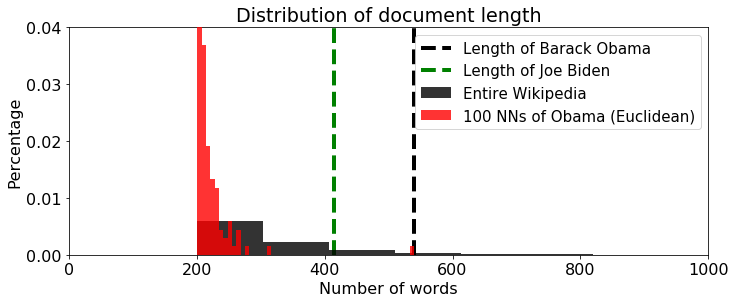

In [106]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki[wiki['name'] == 'Barack Obama']['length'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki[wiki['name'] == 'Joe Biden']['length'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('Number of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [107]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [108]:
#nearest_neighbors_cosine = model2_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)
#nearest_neighbors_cosine = nearest_neighbors_cosine.join(wiki[['name', 'length']], on={'reference_label':'name'})
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(),'id':indices.flatten()})
neighbors.set_index('id',inplace=True)
nearest_neighbors_cosine = wiki.join(neighbors, how ='inner')[['name','length','distance']].sort_values('distance')
nearest_neighbors_cosine.head()

name  length  distance
35817             Barack Obama     540  0.000000
24478                Joe Biden     414  0.703139
38376           Samantha Power     310  0.742982
57108   Hillary Rodham Clinton     580  0.758358
38714  Eric Stern (politician)     255  0.770561

In [109]:
#nearest_neighbors_cosine.sort('rank')

From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

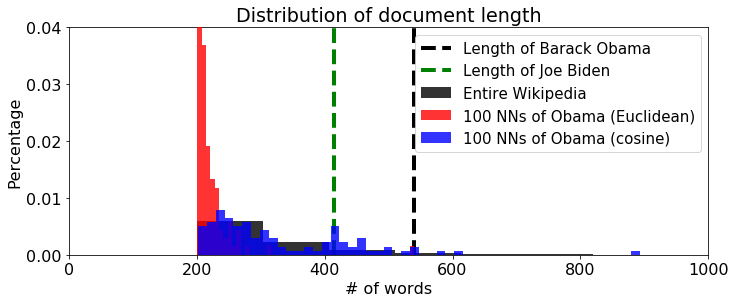

In [110]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [111]:
#sf = graphlab.SFrame({'text': ['democratic governments control law in response to popular act']})
#sf['word_count'] = graphlab.text_analytics.count_words(sf['text'])

#encoder = graphlab.feature_engineering.TFIDF(features=['word_count'], output_column_prefix='tf_idf')
#encoder.fit(wiki)
#sf = encoder.transform(sf)
#sf

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [112]:
tweet = {'act': 3.4597778278724887,
        'control': 3.721765211295327,
        'democratic': 3.1026721743330414,
        'governments': 4.167571323949673,
        'in': 0.0009654063501214492,
        'law': 2.4538226269605703,
        'popular': 2.764478952022998,
        'response': 4.261461747058352,
        'to': 0.04694493768179923}

In [113]:
map_index_to_word.index

Index([u'0', u'00', u'000', u'0000', u'00000', u'00000van', u'0001',
       u'00014338', u'0001sec', u'0002',
       ...
       u'zyx', u'zyzzyva', u'zyzzyza', u'zz', u'zzap64', u'zzb', u'zzebra',
       u'zzran', u'zzt', u'zzts'],
      dtype='object', length=547979)

In [114]:
map_index_to_word[map_index_to_word.index == 'act']

act    547084
dtype: int64

In [115]:
map_index_to_word[map_index_to_word.index == 'act'][0]

547084

In [116]:
word_indices = [map_index_to_word[map_index_to_word.index == word][0] for word in tweet.keys()]

In [117]:
word_indices

[546835, 547972, 547685, 547976, 547084, 547556, 547347, 546136, 546279]

In [119]:
tweet_tf_idf = csr_matrix((list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]))

In [121]:
tweet_tf_idf.shape

(1, 547979)

In [122]:
from sklearn.metrics.pairwise import cosine_distances
obama_tf_idf = tf_idf[35817]
float(cosine_distances(obama_tf_idf, tweet_tf_idf))

0.7059183777794326

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [123]:
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
neighbors.set_index('id', inplace=True)
nearest_neighbors_cosine = wiki.join(neighbors, how = 'inner')[['name', 'distance']].sort_values('distance')
nearest_neighbors_cosine.head(10)

name  distance
35817             Barack Obama  0.000000
24478                Joe Biden  0.703139
38376           Samantha Power  0.742982
57108   Hillary Rodham Clinton  0.758358
38714  Eric Stern (politician)  0.770561
46140             Robert Gibbs  0.784678
6796               Eric Holder  0.788039
44681   Jesse Lee (politician)  0.790926
18827             Henry Waxman  0.798323
2412           Joe the Plumber  0.799466

With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.